In [1]:
PATH="new_housing_ca.csv"

Aim: In the notebook we aim to build and apply a suitable machine learnig model for the housing dataset to forecast home rent prices using a variety of explanatory factors that describe various elements of residential properties.
The dataset we used was originally from craigslist which was having the housing data for the unites states, we have filtered the data for the state of california and will be using the same.

The discrepancy between the real rent and the rent estimated by our model should be as small as possible. The mean squared error (mse) , r2 square and the root squared of the mean squared error will be used to assess model performance (rmse).

In [2]:
#Importing the required libraries
import pyspark.pandas as ps
import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
import numpy as np
import pandas as pd
#for plotting
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline
ps.set_option('compute.ops_on_diff_frames', True)

#for modelling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

In [3]:
#Read the dataset
dataset=ps.read_csv('new_housing_ca.csv')

In [4]:
#we check the columns/features available in the dataset
dataset.info()

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 33085 entries, 0 to 33084
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       33085 non-null  int64  
 1   url                      33085 non-null  object 
 2   region                   33085 non-null  object 
 3   region_url               33085 non-null  object 
 4   price                    33085 non-null  int32  
 5   type                     33085 non-null  object 
 6   sqfeet                   33085 non-null  int32  
 7   beds                     33085 non-null  int32  
 8   baths                    33085 non-null  float64
 9   cats_allowed             33085 non-null  int32  
 10  dogs_allowed             33085 non-null  int32  
 11  smoking_allowed          33085 non-null  int32  
 12  wheelchair_access        33085 non-null  int32  
 13  electric_vehicle_charge  33085 non-null  int32  
 14  comes_furnished    

In [5]:
dataset['lat']=dataset['lat'].astype(int)
dataset['long']=dataset['long'].astype(int)

There are 13 numerical features and 9 categorical features as per pandas.
There are 11 numerical features and 11 categorical features as per spark pandas.
We faced an issue with columns lat and long , in pandas its datatypes is float64 but if we read csv using spark pandas its is changing its datatype to object.
To solve this issue we converted the datatype of lat and long from object to int in the next steps 



In [6]:
#we aim to select few cities/regions from california and work on that so we check the datapoints for regions and select region based on that
dataset['region'].value_counts()

ventura county      2579
stockton            2571
inland empire       2561
orange county       2388
sacramento          2385
san diego           2357
SF bay area         2327
los angeles         2260
fresno / madera     2195
reno / tahoe        1990
bakersfield         1644
palm springs        1409
modesto             1265
monterey bay        1147
hanford-corcoran     815
santa barbara        628
visalia-tulare       449
san luis obispo      448
merced               269
chico                264
gold country         256
redding              237
yuba-sutter          152
humboldt county      145
santa maria          138
imperial county       92
mendocino county      57
siskiyou county       42
susanville            15
Name: region, dtype: int64

In [7]:
#as we can see there are few regions for which the number of data available for houses is less so we try to get only those regions for which data is available
dataset=dataset.loc[ (dataset.region == "bakersfield") | (dataset.region=="orange county") |(dataset.region=="san diego")| (dataset.region=="SF bay area")| (dataset.region=="los angeles")| (dataset.region=="fresno / madera")]

In [8]:
dataset.head(5)

id                                                                                               url           region                          region_url  price       type  sqfeet  beds  baths  cats_allowed  dogs_allowed  smoking_allowed  wheelchair_access  electric_vehicle_charge  comes_furnished  laundry_options  parking_options                                                    image_url                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       description   lat  long     state
0  7043564175       https://bakersfield.craigslist.org/apa/d/bakersfield-central-heating-ac-gas/7043564175.html      bakersfield  https://bakersfield.craigslist.org    980  apartment    1000     2    1.0             0             0                1                  0                        0                0  laundry on site          carport  https://images.craigslist.org/00k0k_ejqvoocN8WH_600x450.jpg                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      "Our

In [9]:
#Next we will check the count of data points for each of the features
dataset.count()

id                         13171
url                        13171
region                     13171
region_url                 13171
price                      13171
type                       13171
sqfeet                     13171
beds                       13171
baths                      13171
cats_allowed               13171
dogs_allowed               13171
smoking_allowed            13171
wheelchair_access          13171
electric_vehicle_charge    13171
comes_furnished            13171
laundry_options            11410
parking_options             9693
image_url                  13171
description                13171
lat                        12577
long                       12657
state                      13171
dtype: int64

From the above count we can infer that there are some data points for some of the features and we will need datacleaning to handle those

In [10]:
# Let's go ahead and find out which variables of the dataset contain missing values.
dataset.isna().mean().sort_values(ascending=False)

parking_options            0.264065
laundry_options            0.133703
lat                        0.045099
long                       0.039025
id                         0.000000
url                        0.000000
region                     0.000000
region_url                 0.000000
price                      0.000000
type                       0.000000
sqfeet                     0.000000
beds                       0.000000
baths                      0.000000
cats_allowed               0.000000
dogs_allowed               0.000000
smoking_allowed            0.000000
wheelchair_access          0.000000
electric_vehicle_charge    0.000000
comes_furnished            0.000000
image_url                  0.000000
description                0.000000
state                      0.000000
dtype: float64

Variables containing missing values:-

parking_options (26%)
laundry_options (13%)
lat (0.05%)
long (0.05%)

In [11]:
#share of each region
dataset.region.value_counts().plot(kind="bar")


In [12]:
#Kernel density estimator
estimator_price=dataset[['price']]
estimator_price.price.plot(kind= 'kde',title="Price KDE plot",bw_method=3)


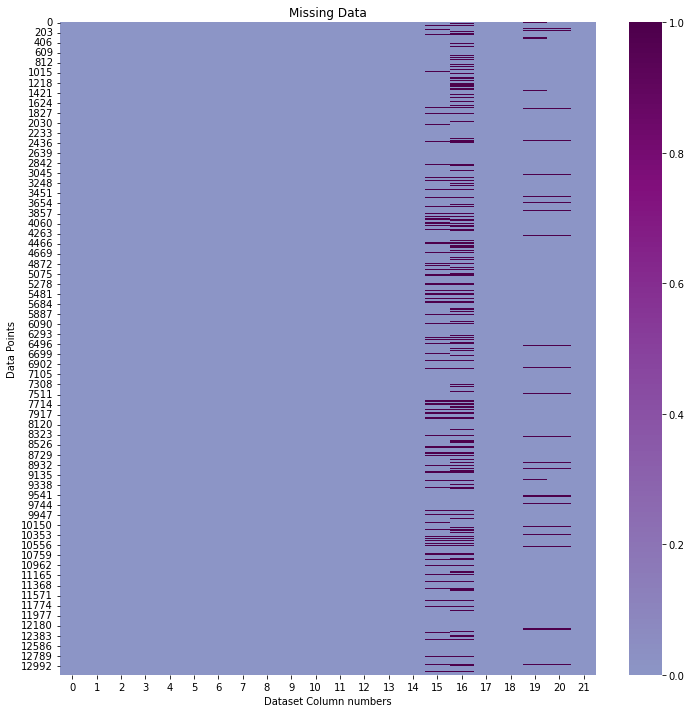

In [13]:
#heat map to get a better understanding of missing data point
#used to_numpy function as we are using spark pandas
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(dataset.isnull().to_numpy(), ax=ax, cmap="BuPu", center=0).set(
            title = 'Missing Data', 
            xlabel = 'Dataset Column numbers', 
            ylabel = 'Data Points');

In [14]:
# make a list of variable that has missing values for future purpose
features_with_NA=[features for features in dataset.columns if dataset[features].isnull().sum() > 0]
print('Number of Features having missing values: ', len(features_with_NA))


Number of Features having missing values:  4


Relationship between missing values and price

we evaluate the price of the house in those observations where the information is missing, for each variable.

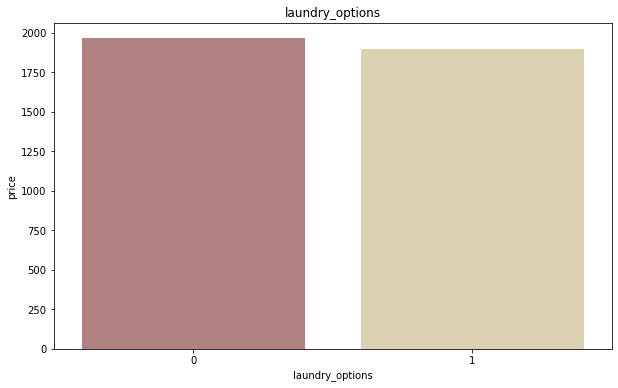

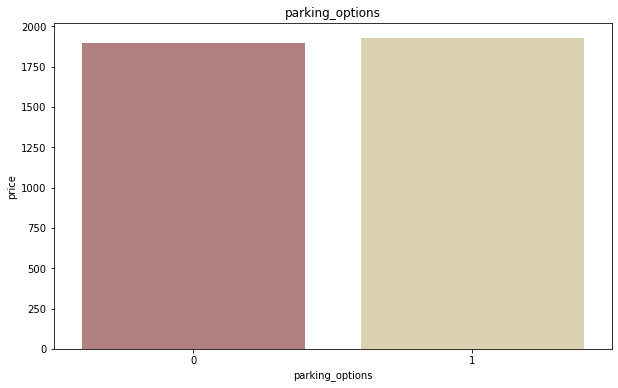

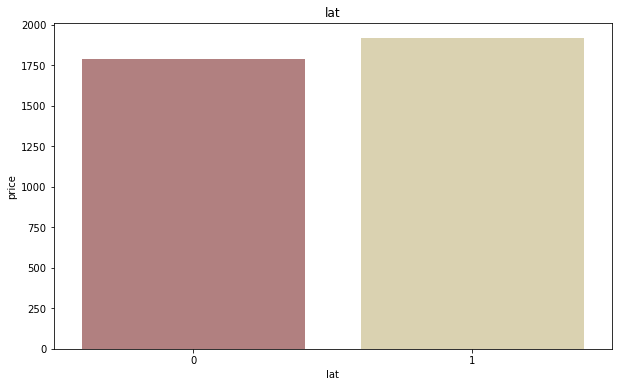

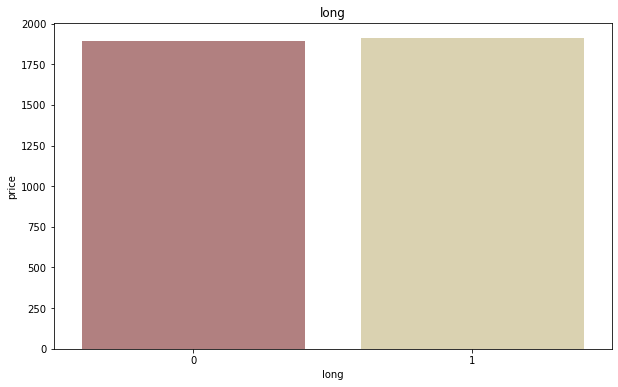

In [15]:
def analyse_null_values(df, var):
    df = dataset.copy().to_pandas()
    # let's make a variable that indicates 0 if the observation was missing or 1 otherwise
    df[var]=np.where(df[var].isna(), 0, 1)
    grs = df.groupby(var)['price'].median().reset_index()
    plt.figure(figsize=(10,6))
    sns.barplot(x=grs[var], y=grs['price'],palette="pink")
    plt.title(var)
    plt.show()
    
# let's run the function on each variable with missing data
for var in features_with_NA:
    analyse_null_values(dataset, var)

From the above graphs we can infer that average rent price in houses where the information is missing, differs from the average rent price in houses where information exists.

In [16]:
#List of categorical variables with missing values
categorical_vars_with_na = [var for var in dataset.columns if dataset[var].isnull().sum() > 0 and dataset[var].dtypes == 'O']
print("Number of categorical variables with missing values",len(categorical_vars_with_na))

Number of categorical variables with missing values 2


In [17]:
#List of numerical variables with missing values
numerical_vars_with_na = [var for var in dataset.columns if dataset[var].isnull().sum() > 0 and dataset[var].dtypes != 'O' ]
print("Number of numerical variables with missing values",len(numerical_vars_with_na))

Number of numerical variables with missing values 2


Now, we will check boolean values

In [18]:
boolean_vars = [var for var in dataset if dataset[var].nunique() == 2]
print("Number of boolean variables",len(boolean_vars))

Number of boolean variables 6


In [19]:
only_numerical_vars = [var for var in dataset.columns if dataset[var].dtypes != 'O' and var not in boolean_vars]
print('Number of numerical variables: ', len(only_numerical_vars))

Number of numerical variables:  7


To handle the numerical and categorical missing values we will use mode and mean imputation in further steps

we will not requre id,url or image_url fields from our dataset as they dont have any impact on the price

Lets plot latitude and langitude to gain more insights

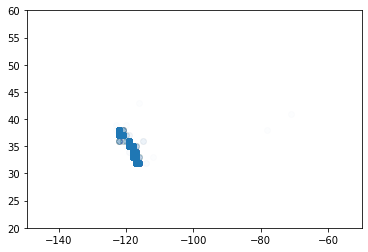

In [20]:
plt.scatter(x=dataset['long'].to_numpy(), y=dataset['lat'].to_numpy(),alpha=0.01)
plt.xlim(right=-50)
plt.ylim(bottom=20,top=60)
plt.show()
#the plot indicates that lat and long for california ranges from 40 to -120

Discrete variables

Let's go ahead and find which variables are discrete, i.e., show a finite number of values



In [21]:
discrete_vars = [var for var in only_numerical_vars if len(dataset[var].unique()) < 13 and var not in ['id', 'price']]
print('Number of discrete variables: ', len(discrete_vars))


Number of discrete variables:  2


The number of rooms and bathrooms are the discrete variables. Let's look at their contribution to the house price now.

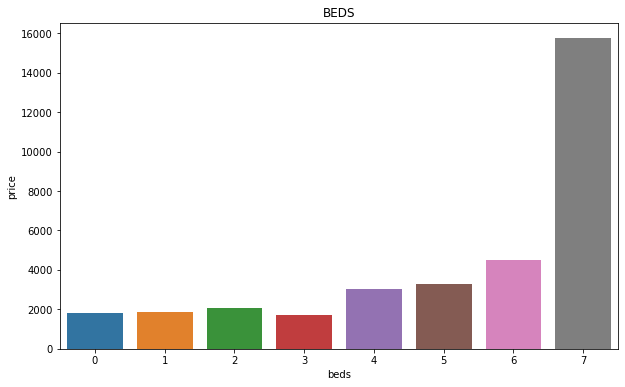

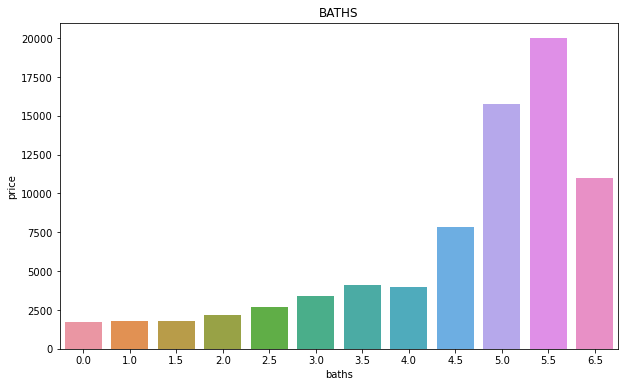

In [22]:
def analyse_discrete(df, var):
    df = dataset.copy().to_pandas()
    grs = df.groupby(var)['price'].median().reset_index()
    plt.figure(figsize=(10,6))
    sns.barplot(x=grs[var], y=grs['price'])
    plt.title(var.upper())
    plt.show()
    
    
for var in discrete_vars:
    analyse_discrete(dataset, var)


The values of the variables and the price have a tendency to correlate, although this connection is not necessarily monotonic.

For example, there is a monotonic relationship in the pricing of beds: the greater the quantity, the higher the price.

In the case of baths, however, the link is not monotonous. Clearly, some bath numbers, such as 5.5, are associated with higher sale prices, but this is not always the case. To get the most out of a linear model, we need to be careful about how we build these variables.

Variables that persist Let's find out how the continuous variables are distributed. All variables in our dataset that are neither temporal or discrete will be considered continuous variables.

In [23]:
# make list of continuous variables
cont_vars = [var for var in only_numerical_vars if var not in discrete_vars+['id']]

print('Number of continuous variables: ', len(cont_vars))
#dataset[cont_vars].head()

Number of continuous variables:  4


C:\Users\shweta\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



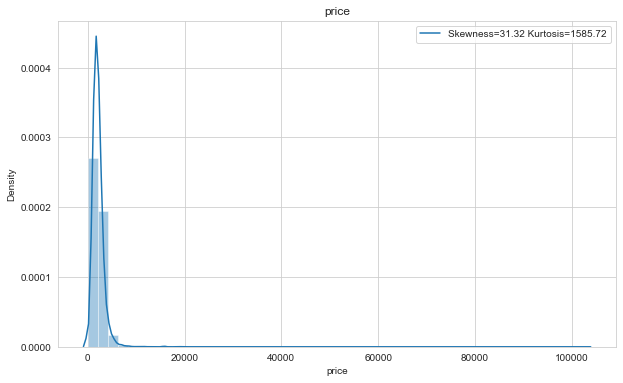

C:\Users\shweta\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



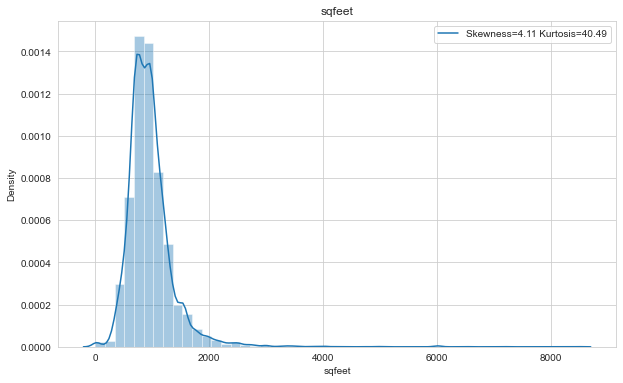

C:\Users\shweta\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



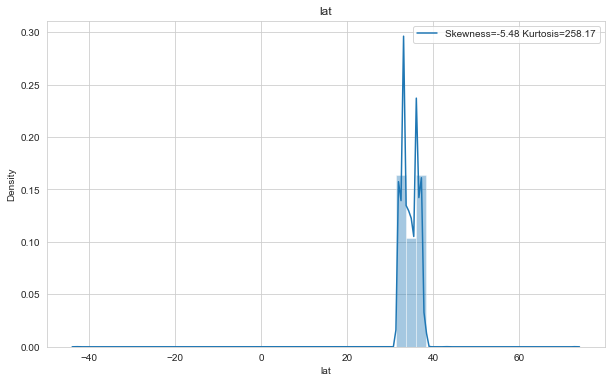

C:\Users\shweta\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



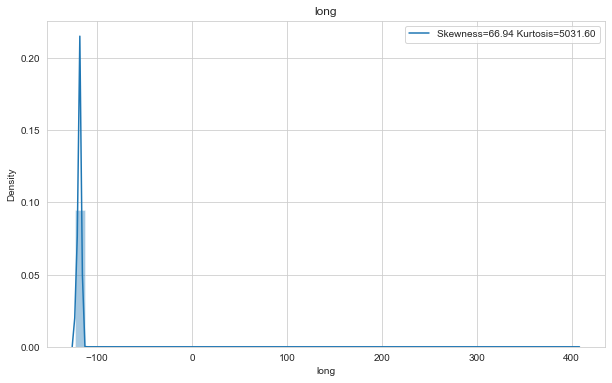

In [24]:
# Let's go ahead and analyse the distributions of these variables
def analyse_continuous(dataset, var):
    dataset = dataset.copy().to_pandas()  
    dataset = dataset.dropna(axis=0)
    plt.figure(figsize=(10,6))
    sns.set_style("whitegrid")
    sns.distplot(dataset[var], hist=True)
    plt.legend(['Skewness={:.2f} Kurtosis={:.2f}'.format(
            dataset[var].skew(), 
            dataset[var].kurt())
        ],
        loc='best')
    plt.title(var)
    plt.show()

for var in cont_vars:
    analyse_continuous(dataset, var)

The variables are not normally distributed, including the target variable 'price'.

To maximise performance of linear models, we need to account for non-Gaussian distributions.

Let's evaluate if a logarithmic transformation of the variables returns values that follow a normal distribution:

Dist plot after log transformation

C:\Users\shweta\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



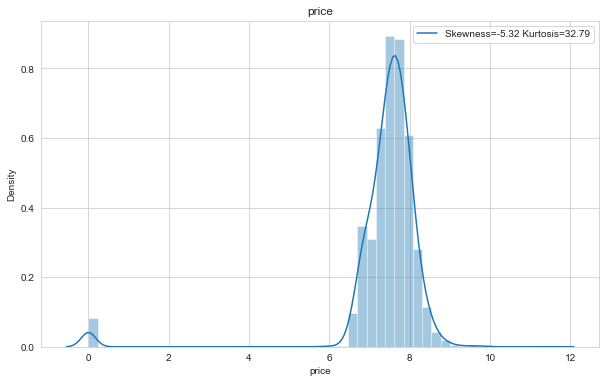

C:\Users\shweta\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



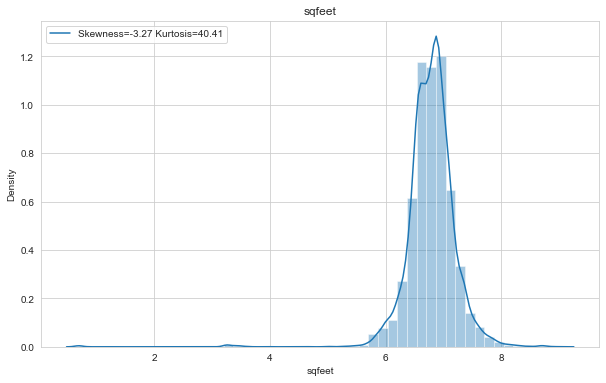

C:\Users\shweta\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



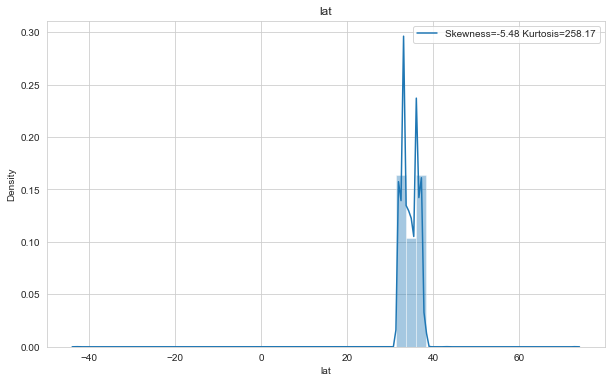

C:\Users\shweta\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



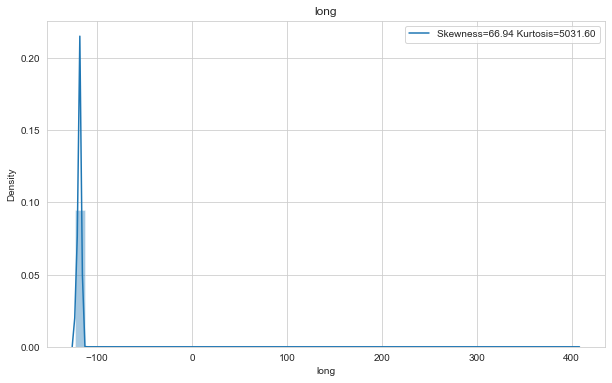

In [25]:
def analyse_transformed_continuous(dataset, var):
    dataset = dataset.copy().to_pandas()
    dataset = dataset.dropna(axis=0)

    # log does not take 0 or negative values, so let's be
    # careful and skip those variables
    if var == 'lat' or var == 'long':
        pass
    else:
        # log transform the variable
        dataset[var] = np.log1p(dataset[var])
    plt.figure(figsize=(10,6))
    sns.set_style("whitegrid")
    sns.distplot(dataset[var], hist=True)
    plt.legend(['Skewness={:.2f} Kurtosis={:.2f}'.format(
            dataset[var].skew(), 
            dataset[var].kurt())
        ],
        loc='best')
    plt.title(var)
    plt.show()


for var in cont_vars:
    analyse_transformed_continuous(dataset, var)


We get a better spread of the values for most variables when we use the logarithmic transformation. This engineering step will most likely add performance value to our final model.

From the previous plots, we observe some monotonic associations between price and the variables to which we applied the log transformation, for example 'sqfeet'.

Finding of Outliers

In [26]:
# let's make boxplots to visualise outliers in the continuous variables


def find_outliers(dataset, var):
    dataset = dataset.copy().to_pandas()

    # log does not take negative values, so let's be
    # careful and skip those variables
    if var == 'lat' or var == 'long':
        pass
    else:
        # log transform the variable
        dataset[var] = np.log1p(dataset[var])
    ax = sns.boxplot(x=dataset[var], palette="flag", orient="horizontal")
    plt.title(var)
    plt.ylabel(var)
    plt.show()

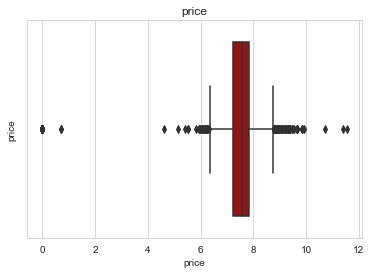

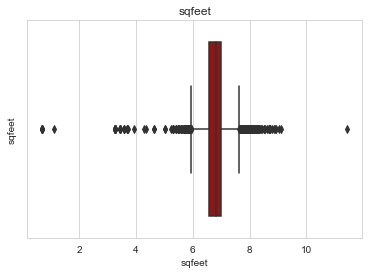

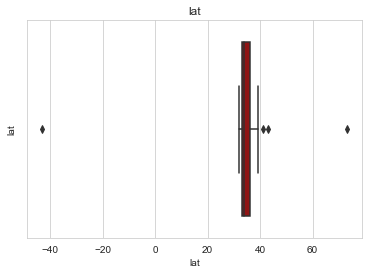

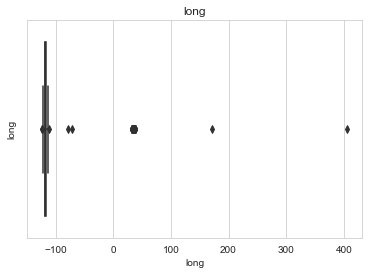

In [27]:
for var in cont_vars:
    find_outliers(dataset, var)

The majority of the continuous variables seem to contain outliers. Outliers tend to affect the performance of linear model. So we will handle outliers in the data
cleaning step.


In [28]:
def out_iqr(dataset, column):
    global lower,upper
    q25, q75 = np.quantile(dataset[column].to_numpy(), 0.25), np.quantile(dataset[column].to_numpy(), 0.75)
    # calculate the IQR
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    # calculate the lower and upper bound value
    lower, upper = q25 - cut_off, q75 + cut_off
    print('The IQR is',iqr)
    print('The lower bound value is', lower)
    print('The upper bound value is', upper)
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = dataset[dataset[column] > upper]
    df2 = dataset[dataset[column] < lower]
    return print('Total number of outliers are', df1.shape[0]+ df2.shape[0])

In [29]:
out_iqr(dataset, 'price')

The IQR is 1155.0
The lower bound value is -337.5
The upper bound value is 4282.5
Total number of outliers are 522


In [30]:
out_iqr(dataset, 'sqfeet')

The IQR is 383.0
The lower bound value is 142.5
The upper bound value is 1674.5
Total number of outliers are 566


In [31]:
out_iqr(dataset, 'beds')

The IQR is 1.0
The lower bound value is -0.5
The upper bound value is 3.5
Total number of outliers are 323


In [32]:
out_iqr(dataset, 'baths')

The IQR is 1.0
The lower bound value is -0.5
The upper bound value is 3.5
Total number of outliers are 46


Pie chart for analysing type of apartment and their prices

In [33]:
grdsp = dataset.groupby(["type"])[["price"]].mean().reset_index()

fig = px.pie(grdsp,
             values=grdsp['price'].to_numpy(),
             names=grdsp['type'].to_numpy(),
             template="seaborn")
fig.update_traces(rotation=90, pull=0.05, textinfo="percent+label")
fig.show()


We can see that the majority of the houses are of type flat with around 14% of the total records.
The mean price for the type apartment is around 3208.

In [34]:
#Type wise catplot for regions
#viz_3.set_xticklabels(rotation=90)

Correlation Heatmap

<AxesSubplot:>

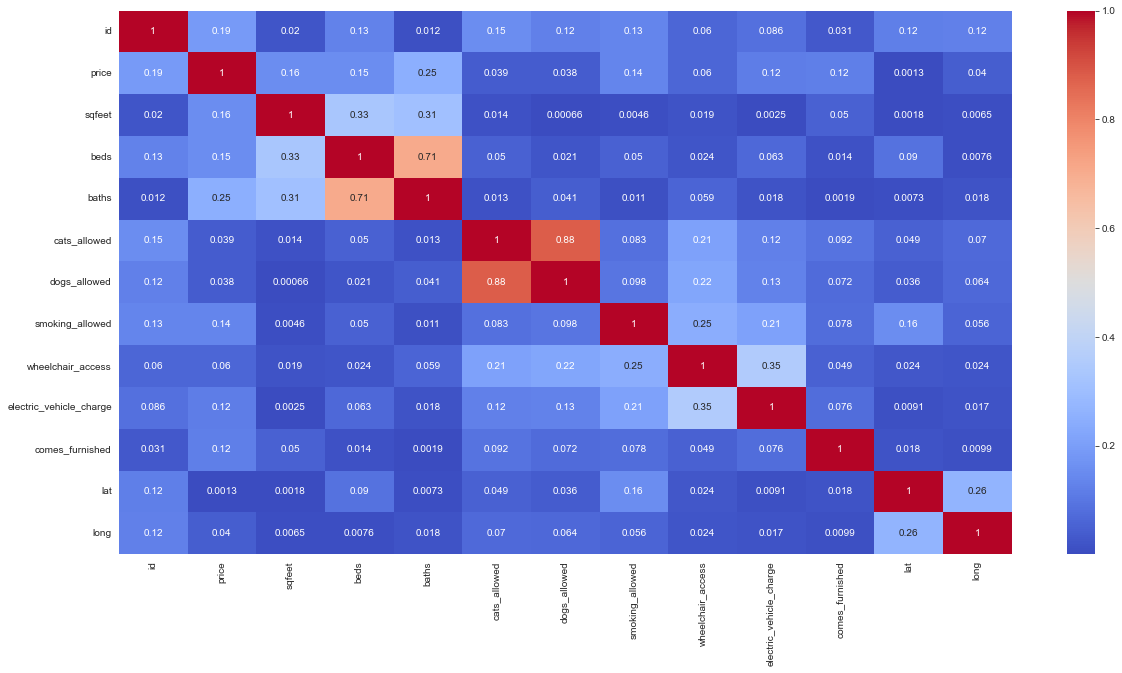

In [35]:
df=dataset.copy().to_pandas()
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr().abs(),  annot=True, cmap='coolwarm')


We have done EDA for the dataset and now will proceed with data cleaning stage

In [36]:
#lets start with the number of baths
#as we can see in the dataset we are having floating point values for the baths column so to handle those we round them off
dataset['baths']=np.ceil(dataset['baths']).astype(int)

In [37]:
#mode imputation of categorical values
def impute_missing_categorical_values(df, var, modeof):
    return df.groupby(modeof)[var].transform(lambda x: x.fillna(x.mode()[0]))

In [38]:

dataset['laundry_options'] = impute_missing_categorical_values(dataset, 'laundry_options', 'type')
dataset['parking_options'] = impute_missing_categorical_values(dataset, 'parking_options', 'type')


In [39]:
dataset = dataset.dropna(subset=["state", "description"],axis=0)

In [40]:
#mode imputation of numerical values
def impute_missing_numerical_values(df, var, meanof):
    return df.groupby(meanof)[var].transform(lambda x: x.fillna(x.mode()[0]))

In [41]:
dataset["lat"] = impute_missing_numerical_values(dataset, "lat", "region")
dataset["long"] = impute_missing_numerical_values(dataset, "long", "region")

In EDA, we decided to remove outliers according to the upper and lower bound of its interquartile range.

In [42]:
price_upper, price_lower = 4283, 1
sqfeet_upper, sqfeet_lower = 1675, 1
beds_upper, beds_lower = 3, 1
baths_upper, baths_lower = 3, 1

In [43]:
dataset = dataset[(dataset['price'] <= price_upper) & (dataset['price'] >= price_lower)]
dataset = dataset[(dataset['sqfeet'] <= sqfeet_upper) & (dataset['sqfeet'] >= sqfeet_lower)]
dataset = dataset[(dataset['beds'] <= beds_upper) & (dataset['beds'] >= beds_lower)]
dataset = dataset[(dataset['baths'] <= baths_upper) & (dataset['baths'] >= baths_lower)]

Adding more features from description column

In [44]:
dataset['beds_per_sqfeet'] = dataset['beds'] / dataset['sqfeet']
dataset['baths_per_beds'] = dataset['baths'] / dataset['beds']
dataset['has_pool'] = dataset['description'].apply(lambda x: 1 if 'pool' in x.lower() or 'swimming' in x.lower() else 0)
dataset['gym_nearby'] = dataset['description'].apply(lambda x: 1 if 'gym' in x.lower() or 'fitness' in x.lower() else 0)
dataset['wifi_facilities'] = dataset['description'].apply(lambda x: 1 if 'wifi' in x.lower() or 'wi-fi' in x.lower() else 0)
dataset['dining_nearby'] = dataset['description'].apply(lambda x: 1 if 'dining' in x.lower() else 0)

Numerical Variable Transformation

We will log transform the positive numerical variables in order to get a more Gaussian-like distribution. This tends to help Linear machine learning models.


In [45]:
for var in ['price','sqfeet','baths_per_beds','beds_per_sqfeet']:
    dataset[var] = np.log(dataset[var])

Encoding of categorical variables
Next, we need to transform the strings of the categorical variables into numbers. We will do it so that we capture the monotonic relationship between the label and the target.

In [46]:
categorical_vars_for_encoding = ['region', 'type', 'laundry_options', 'parking_options']

In [47]:
def replace_categorical_values(dataset, var, target):

    # order the categories in a variable from that with the lowest
    # house sale price, to that with the highest
    ordered_labels = dataset.groupby([var])[target].mean().sort_values().index.to_numpy()

    # create a dictionary of ordered categories to integer values
    ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}

    # use the dictionary to replace the categorical strings by integers
    dataset[var] = dataset[var].map(ordinal_label)

In [48]:

for var in categorical_vars_for_encoding:
    replace_categorical_values(dataset, var, 'price')

In [49]:
dataset.count()

id                         11207
url                        11207
region                     11207
region_url                 11207
price                      11207
type                       11207
sqfeet                     11207
beds                       11207
baths                      11207
cats_allowed               11207
dogs_allowed               11207
smoking_allowed            11207
wheelchair_access          11207
electric_vehicle_charge    11207
comes_furnished            11207
laundry_options            11207
parking_options            11207
image_url                  11207
description                11207
lat                        11207
long                       11207
state                      11207
beds_per_sqfeet            11207
baths_per_beds             11207
has_pool                   11207
gym_nearby                 11207
wifi_facilities            11207
dining_nearby              11207
dtype: int64

In [50]:
features = ['region', 'price', 'type', 'sqfeet', 'smoking_allowed', 'wheelchair_access', 
            'electric_vehicle_charge', 'comes_furnished', 'laundry_options', 'parking_options','lat', 'long','beds_per_sqfeet', 'baths_per_beds', 'has_pool', 
             'gym_nearby', 'wifi_facilities', 'dining_nearby']

data_final = dataset[features].copy()
data_final.head()

region     price type    sqfeet  smoking_allowed  wheelchair_access  electric_vehicle_charge  comes_furnished laundry_options parking_options   lat   long  beds_per_sqfeet  baths_per_beds  has_pool  gym_nearby  wifi_facilities  dining_nearby
0      0  6.887553    4  6.907755                1                  0                        0                0               1               0  35.0   35.0        -6.214608       -0.693147         1           0                0              1
1      0  6.551080    4  6.684612                1                  0                        0                0               4               0  35.0 -119.0        -5.991465       -0.693147         0           0                0              0
2      1  7.056175    4  6.677083                1                  0                        0                0               4               0  36.0 -119.0        -6.677083        0.000000         1           1                0              0
3      1  7.332369    4  7.063904                0                  1                        0                0               4               3  36.0 -119.0        -6.370757        0.000000         1           1                1              1
5      0  7.130899    3  7.207860                0                  0                        0                0               0               3  35.0 -119.0        -6.109248       -0.405465         0           0                0              0

In [51]:
for feature in features:
    data_final[feature] = data_final[feature].astype(np.float64)

In [52]:
data_final=data_final.to_pandas()


In [53]:
#Done till here

In [54]:
input_features= data_final.drop('price',axis=1)
price=data_final['price']

In [55]:
from sklearn.model_selection import train_test_split

input_train, input_test, output_train, output_test = train_test_split(input_features,price,test_size=0.30,random_state=10)

In [56]:
price = data_final['price']
features = data_final.drop(['price'], axis=1)

In [57]:
input_train, input_test, output_train, output_test = train_test_split(features, price, test_size=0.33, random_state=101)

In [58]:
scaled_data = StandardScaler()

scaled_input_train = scaled_data.fit_transform(input_train)
scaled_input_test = scaled_data.fit_transform(input_test)
scaled_output_train = output_train
scaled_output_test = output_test

In [59]:
model = LinearRegression()
model.fit(input_train,output_train)

scaled_model = LinearRegression()
scaled_model.fit(scaled_input_train,scaled_output_train)

LinearRegression()

In [60]:
pred_model = model.predict(input_test)
pred_model_scaled = scaled_model.predict(scaled_input_test)

In [61]:
print('Linear Regression Performance:')

print('\nall features, No scaling:')
print('MAE:', metrics.mean_absolute_error(output_test, pred_model))
print('RMSE:', np.sqrt(metrics.mean_squared_error(output_test, pred_model)))
print('R2_Score: ', metrics.r2_score(output_test, pred_model))

print('\nall features, with scaling:')
print('MAE:', metrics.mean_absolute_error(scaled_output_test, pred_model_scaled))
print('RMSE:', np.sqrt(metrics.mean_squared_error(scaled_output_test, pred_model_scaled)))
print('R2_Score: ', metrics.r2_score(scaled_output_test, pred_model_scaled))

pred = pd.DataFrame(data={'Predicted_Rent': np.exp(pred_model_scaled), 'Actual_Rent': np.exp(scaled_output_test)})

Linear Regression Performance:

all features, No scaling:
MAE: 0.16653148183358163
RMSE: 0.25915872607321633
R2_Score:  0.6335267308420381

all features, with scaling:
MAE: 0.16606097860518
RMSE: 0.2593875159688383
R2_Score:  0.6328793870897309


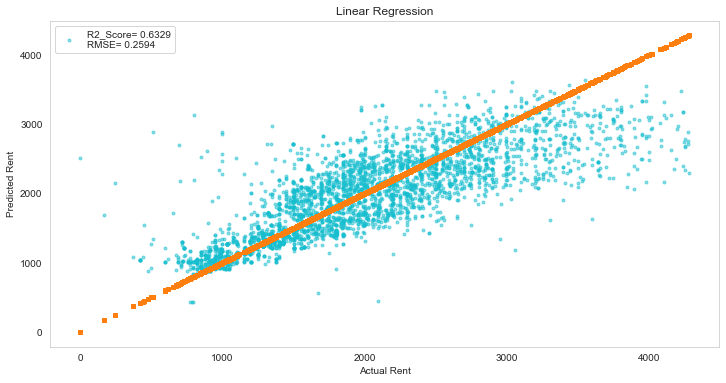

In [62]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(pred['Actual_Rent'], pred['Predicted_Rent'], color='tab:cyan', marker=".", label='Predicted', alpha=0.5)
ax1.scatter(pred['Actual_Rent'], pred['Actual_Rent'], s=10, color='tab:orange', marker="s", label='Actual')

plt.xlabel('Actual Rent')
plt.ylabel('Predicted Rent')
plt.legend(['R2_Score= {:.4f}\nRMSE= {:.4f} '.format(
                metrics.r2_score(scaled_output_test, pred_model_scaled), 
                np.sqrt(metrics.mean_squared_error(scaled_output_test, pred_model_scaled)))
           ],
           loc='best')
plt.title('Linear Regression')
plt.grid()
plt.show()

Random Forest

In [63]:
Random_forest_model = RandomForestRegressor(random_state=101, n_estimators=200)
Random_forest_model_scaled = RandomForestRegressor(random_state=101, n_estimators=200)

Random_forest_model.fit(input_train, output_train)
Random_forest_model_scaled.fit(scaled_input_train, scaled_output_train)

RandomForestRegressor(n_estimators=200, random_state=101)

In [64]:
RF_pred = Random_forest_model.predict(input_test)
RF_pred_scaled = Random_forest_model_scaled.predict(scaled_input_test)

Random Forest Performance:

all features, No scaling:
MAE: 0.07652615790629952
RMSE: 0.18990479919891662
R2_Score:  0.8032192960530216

all features, with scaling:
MAE: 0.10251217739171954
RMSE: 0.20295855603601923
R2_Score:  0.7752367215109339


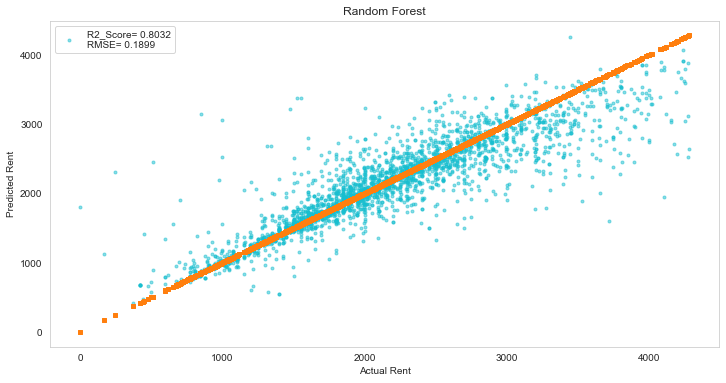

In [65]:
print('Random Forest Performance:')

print('\nall features, No scaling:')
print('MAE:', metrics.mean_absolute_error(output_test, RF_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(output_test, RF_pred)))
print('R2_Score: ', metrics.r2_score(output_test, RF_pred))

print('\nall features, with scaling:')
print('MAE:', metrics.mean_absolute_error(scaled_output_test, RF_pred_scaled))
print('RMSE:', np.sqrt(metrics.mean_squared_error(scaled_output_test, RF_pred_scaled)))
print('R2_Score: ', metrics.r2_score(scaled_output_test, RF_pred_scaled))

pred = pd.DataFrame(data={'Predicted_Rent': np.exp(RF_pred), 'Actual_Rent': np.exp(output_test)})

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(pred['Actual_Rent'], pred['Predicted_Rent'], color='tab:cyan', marker=".", label='Predicted', alpha=0.5)
ax1.scatter(pred['Actual_Rent'], pred['Actual_Rent'], s=10, color='tab:orange', marker="s", label='Actual')

plt.xlabel('Actual Rent')
plt.ylabel('Predicted Rent')
plt.legend(['R2_Score= {:.4f}\nRMSE= {:.4f} '.format(
                metrics.r2_score(output_test, RF_pred), 
                np.sqrt(metrics.mean_squared_error(output_test, RF_pred)))
           ],
           loc='best')
plt.title('Random Forest')
plt.grid()
plt.show()

Gradient Boosting

In [66]:
Gradient_boost = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, min_samples_split=2, 
                                 min_samples_leaf=1, max_depth=3, subsample=1.0, max_features= None, 
                                 random_state=101)

Gradient_boost.fit(input_train, output_train)

GradientBoostingRegressor(random_state=101)

In [67]:
Gradient_boost_pred = Gradient_boost.predict(input_test)


Gradiant Boosting Performance:

all features, No scaling:
MAE: 0.12164815450468487
RMSE: 0.2192310385148911
R2_Score:  0.7377504740874883


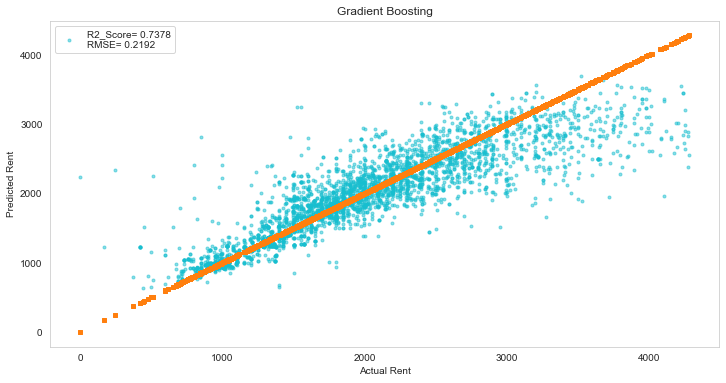

In [68]:
print('Gradiant Boosting Performance:')

print('\nall features, No scaling:')
print('MAE:', metrics.mean_absolute_error(output_test, Gradient_boost_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(output_test, Gradient_boost_pred)))
print('R2_Score: ', metrics.r2_score(output_test, Gradient_boost_pred))

pred = pd.DataFrame(data={'Predicted_Rent': np.exp(Gradient_boost_pred), 'Actual_Rent': np.exp(output_test)})

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(pred['Actual_Rent'], pred['Predicted_Rent'], color='tab:cyan', marker=".", label='Predicted', alpha=0.5)
ax1.scatter(pred['Actual_Rent'], pred['Actual_Rent'], s=10, color='tab:orange', marker="s", label='Actual')

plt.xlabel('Actual Rent')
plt.ylabel('Predicted Rent')
plt.legend(['R2_Score= {:.4f}\nRMSE= {:.4f} '.format(
                metrics.r2_score(output_test, Gradient_boost_pred), 
                np.sqrt(metrics.mean_squared_error(output_test, Gradient_boost_pred)))
           ],
           loc='best')
plt.title('Gradient Boosting')
plt.grid()
plt.show()

In [69]:
xg_boost = XGBRegressor(learning_rate=0.1, n_estimators=100, 
                    min_samples_split=2, min_samples_leaf=1, 
                    max_depth=3, subsample=1.0, random_state=101)

xg_boost.fit(input_train, output_train)

[10:04:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             min_samples_leaf=1, min_samples_split=2, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=101, ...)

In [70]:
xg_boost_pred = xg_boost.predict(input_test)


XgBoost Performance:

all features, No scaling:
MAE: 0.12189519973784245
RMSE: 0.21984535380121487
R2_Score:  0.7362786969957245


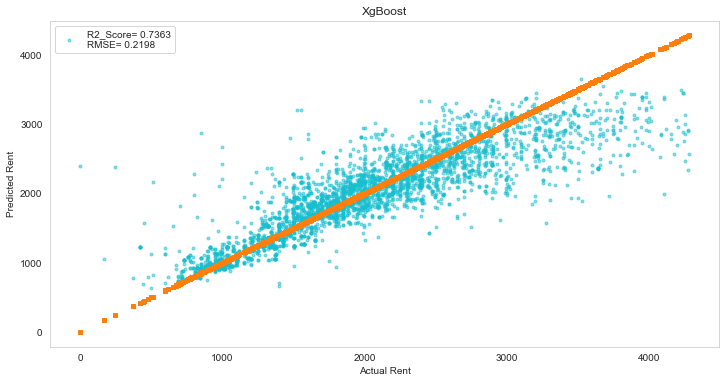

In [71]:
print('XgBoost Performance:')

print('\nall features, No scaling:')
print('MAE:', metrics.mean_absolute_error(output_test, xg_boost_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(output_test, xg_boost_pred)))
print('R2_Score: ', metrics.r2_score(output_test, xg_boost_pred))

pred = pd.DataFrame(data={'Predicted_Rent': np.exp(xg_boost_pred), 'Actual_Rent': np.exp(output_test)})

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(pred['Actual_Rent'], pred['Predicted_Rent'], color='tab:cyan', marker=".", label='Predicted', alpha=0.5)
ax1.scatter(pred['Actual_Rent'], pred['Actual_Rent'], s=10, color='tab:orange', marker="s", label='Actual')

plt.xlabel('Actual Rent')
plt.ylabel('Predicted Rent')
plt.legend(['R2_Score= {:.4f}\nRMSE= {:.4f} '.format(
                metrics.r2_score(output_test, xg_boost_pred), 
                np.sqrt(metrics.mean_squared_error(output_test, xg_boost_pred)))
           ],
           loc='best')
plt.title('XgBoost')
plt.grid()
plt.show()

Decision Tree Regressor

Decision Tree Performance:

all features, No scaling:
MAE: 0.0884537329686061
RMSE: 0.2190613285381502
R2_Score:  0.7381563393767234


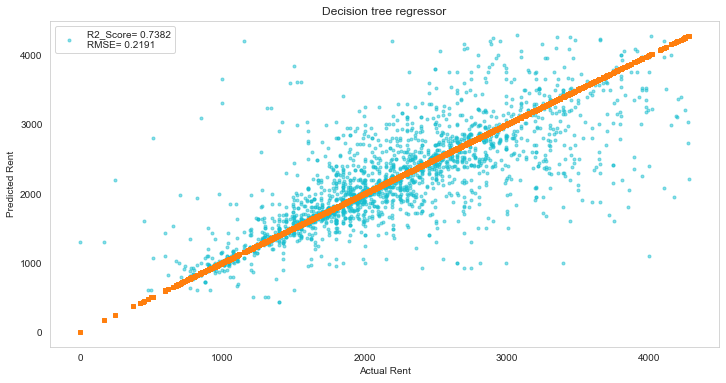

In [72]:
from sklearn.tree import DecisionTreeRegressor
Dtree_model = DecisionTreeRegressor(random_state=1)
Dtree_model.fit(input_train, output_train)
DecisionTreeRegressor(random_state=1)
Dtree_model_predicted = Dtree_model.predict(input_test)
Dtree_model_score = Dtree_model.score(input_test, output_test)
#Dtree_model_score

print('Decision Tree Performance:')

print('\nall features, No scaling:')
print('MAE:', metrics.mean_absolute_error(output_test, Dtree_model_predicted))
print('RMSE:', np.sqrt(metrics.mean_squared_error(output_test, Dtree_model_predicted)))
print('R2_Score: ', metrics.r2_score(output_test, Dtree_model_predicted))

pred = pd.DataFrame(data={'Predicted_Rent': np.exp(Dtree_model_predicted), 'Actual_Rent': np.exp(output_test)})

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(pred['Actual_Rent'], pred['Predicted_Rent'], color='tab:cyan', marker=".", label='Predicted', alpha=0.5)
ax1.scatter(pred['Actual_Rent'], pred['Actual_Rent'], s=10, color='tab:orange', marker="s", label='Actual')

plt.xlabel('Actual Rent')
plt.ylabel('Predicted Rent')
plt.legend(['R2_Score= {:.4f}\nRMSE= {:.4f} '.format(
                metrics.r2_score(output_test, Dtree_model_predicted), 
                np.sqrt(metrics.mean_squared_error(output_test, Dtree_model_predicted)))
           ],
           loc='best')
plt.title('Decision tree regressor')
plt.grid()
plt.show()


Bagging Regressor

Bagging Regressor Performance:

all features, No scaling:
MAE: 0.08057707293705152
RMSE: 0.19363238143684947
R2_Score:  0.79541838484745


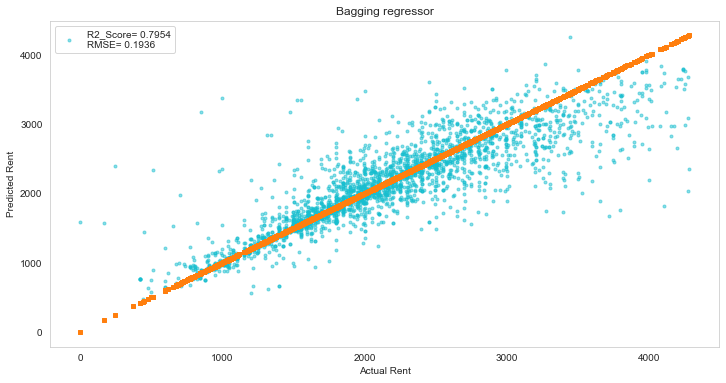

In [73]:

from sklearn.ensemble import  BaggingRegressor 
from sklearn.ensemble import  AdaBoostRegressor
BGR_model = BaggingRegressor()
BGR_model.fit(input_train, output_train)
BGR_model_predicted = BGR_model.predict(input_test)
BGR_model_score = BGR_model.score(input_test, output_test)

print('Bagging Regressor Performance:')

print('\nall features, No scaling:')
print('MAE:', metrics.mean_absolute_error(output_test, BGR_model_predicted))
print('RMSE:', np.sqrt(metrics.mean_squared_error(output_test, BGR_model_predicted)))
print('R2_Score: ', metrics.r2_score(output_test, BGR_model_predicted))

pred = pd.DataFrame(data={'Predicted_Rent': np.exp(BGR_model_predicted), 'Actual_Rent': np.exp(output_test)})

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(pred['Actual_Rent'], pred['Predicted_Rent'], color='tab:cyan', marker=".", label='Predicted', alpha=0.5)
ax1.scatter(pred['Actual_Rent'], pred['Actual_Rent'], s=10, color='tab:orange', marker="s", label='Actual')

plt.xlabel('Actual Rent')
plt.ylabel('Predicted Rent')
plt.legend(['R2_Score= {:.4f}\nRMSE= {:.4f} '.format(
                metrics.r2_score(output_test, BGR_model_predicted), 
                np.sqrt(metrics.mean_squared_error(output_test, BGR_model_predicted)))
           ],
           loc='best')
plt.title('Bagging regressor')
plt.grid()
plt.show()



Ada Boost regressor

ADB Regressor Performance:

all features, No scaling:
MAE: 0.18952686132161842
RMSE: 0.2715547485463745
R2_Score:  0.5976301487746394


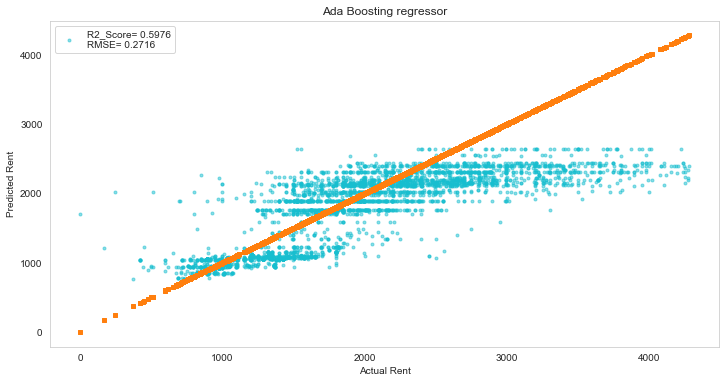

In [74]:
ADB_model = AdaBoostRegressor()
ADB_model.fit(input_train, output_train)
ADB_model_predicted = ADB_model.predict(input_test)
ADB_model_score = ADB_model.score(input_test, output_test)


print('ADB Regressor Performance:')

print('\nall features, No scaling:')
print('MAE:', metrics.mean_absolute_error(output_test, ADB_model_predicted))
print('RMSE:', np.sqrt(metrics.mean_squared_error(output_test, ADB_model_predicted)))
print('R2_Score: ', metrics.r2_score(output_test, ADB_model_predicted))

pred = pd.DataFrame(data={'Predicted_Rent': np.exp(ADB_model_predicted), 'Actual_Rent': np.exp(output_test)})

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(pred['Actual_Rent'], pred['Predicted_Rent'], color='tab:cyan', marker=".", label='Predicted', alpha=0.5)
ax1.scatter(pred['Actual_Rent'], pred['Actual_Rent'], s=10, color='tab:orange', marker="s", label='Actual')

plt.xlabel('Actual Rent')
plt.ylabel('Predicted Rent')
plt.legend(['R2_Score= {:.4f}\nRMSE= {:.4f} '.format(
                metrics.r2_score(output_test, ADB_model_predicted), 
                np.sqrt(metrics.mean_squared_error(output_test, ADB_model_predicted)))
           ],
           loc='best')
plt.title('Ada Boosting regressor')
plt.grid()
plt.show()

